# Employee Attrition Dataset: Structure Learning

### First we need to import some modules

In [1]:
import os 
from pprint import pprint

import networkx as nx
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pgmpy.models
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch


%matplotlib inline

### now we read the dataset, we use the IBM Employee Attition Dataset here

In [2]:
data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### get rid of unneccessary columns:


In [3]:
# Employee Count and StandardHours contain 1 resp. 80 for every record, so we can drop them
unnecessary_columns = ["EmployeeCount", "StandardHours"] 
data = data.drop(columns=unnecessary_columns)

### we could try to learn the structure from the data, but we can also think about what we can influence.
In the end we care about attrition. We suppose, attrition is an effect of Job Satisfaction, but we cannot influence the job satisfaction itself. 
Instead we could influence
* increase daily rate
* decrease Business Travel
* reduce OverTime



In [4]:
# Funtion to evaluate the learned model structures.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_matrix(estimated_model.to_undirected(), nodelist=nodes, weight=None)
    true_adj = nx.to_numpy_matrix(true_model.to_undirected(), nodelist=nodes, weight=None)
    
    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)


In [5]:
est = PC(data=data)
#estimated_model = est.estimate(variant='stable', max_cond_vars=4)
#get_f1_score(estimated_model, model)
estimated_model = est.estimate(variant='orig', max_cond_vars=4)



Working for n conditional variables: 4: 100%|██████████| 4/4 [01:07<00:00, 16.81s/it]


In [6]:
print(estimated_model.edges)


[('BusinessTravel', 'PercentSalaryHike'), ('PerformanceRating', 'PercentSalaryHike'), ('NumCompaniesWorked', 'Age'), ('Department', 'EducationField'), ('JobRole', 'Department'), ('Attrition', 'OverTime'), ('YearsAtCompany', 'YearsInCurrentRole'), ('YearsWithCurrManager', 'YearsAtCompany'), ('YearsWithCurrManager', 'TotalWorkingYears'), ('StockOptionLevel', 'MaritalStatus'), ('TotalWorkingYears', 'YearsAtCompany')]


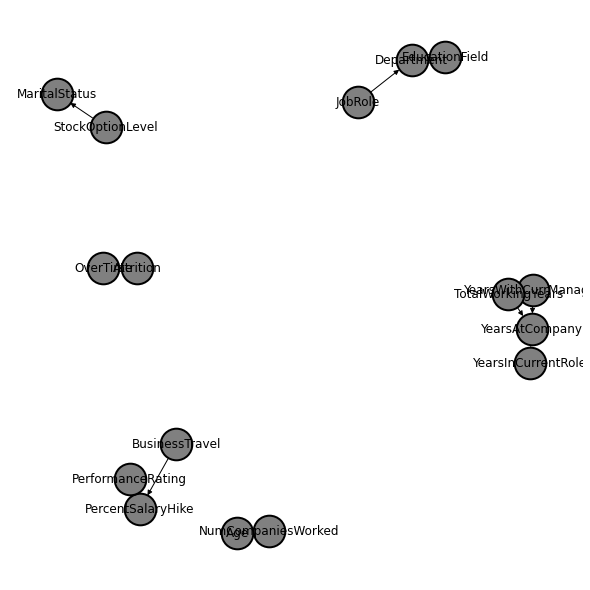

In [7]:
import networkx as nx
import matplotlib.pyplot as plt 

G = nx.MultiDiGraph()

G.add_edges_from(
    estimated_model.edges
)

plt.figure(figsize=(8,8))
nx.draw(G, with_labels = True, node_size=1000, node_color="grey", linewidths=2)
 
ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor("#000000") 